In [1]:
%load_ext autoreload
%autoreload 2

# Import

In [ ]:
import wandb
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.progress import RichProgressBar
from pytorch_lightning.loggers import WandbLogger
from sav.datamodule import DatamoduleSAV
from sav.module.fs_segmenter import FewShotSegmenter
wandb.login()

# Set config

In [8]:
args = dict(# checkpoint
            seed=0, 
            num_epoch=1,
            checkpoint_path='results/test',
            model_name='test',
            version='0',
            precision_for_training=16,
    
            # model
            backbone='vgg16', 
            optimizer='adam', 
            learning_rate=1e-4, 
            weight_decay=1e-5,
    
            # datamodule
            datapath='demo_data/train',
            nshot=3,
            nsamples=500,
            contrast=(0.5,1.5),
            rotation_degrees=90.0,
            scale=(0.25,1.0),
            crop_size=256,
            val_data_ratio=0.15,
            batch_size=5,
            n_cpu=4,
            )

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


# Initialise logger and callback

In [ ]:
# Set Logger
logger = WandbLogger(save_dir="lightning_logs",
                     project="slice-and-view_avgpool"
                     )

# Set checkpoints paths
checkpoint_callback = ModelCheckpoint(
                            save_top_k=5,
                            monitor="val/val_loss",
                            mode="min",
                            dirpath=args['checkpoint_path'],
                            filename= args['model_name'] + "-{epoch:02d}",
                         )

# Initialise datamodule and module

In [10]:
pl.seed_everything(args['seed'])

datamodule = DatamoduleSAV(datapath=args['datapath'],
                           nshot=args['nshot'],
                           nsamples=args['nsamples'],
                           contrast=args['contrast'],
                           rotation_degrees=args['rotation_degrees'],
                           scale=args['scale'],
                           crop_size=args['crop_size'],
                           val_data_ratio=args['val_data_ratio'],
                           batch_size=args['batch_size'],
                           n_cpu=args['n_cpu'])

model = FewShotSegmenter(backbone=args['backbone'],
                         optimizer=args['optimizer'],
                         learning_rate=args['learning_rate'],
                         weight_decay=args['weight_decay'])

Global seed set to 0


# Initialise trainer and start training

In [11]:
trainer = pl.Trainer(max_epochs=args['num_epoch'], 
                     callbacks=[RichProgressBar(),checkpoint_callback],
                     logger=logger, 
                     precision=args['precision_for_training'],
                     accelerator='gpu', 
                     devices=1)

trainer.fit(model, datamodule)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/itf-fi-ml/home/poyenyt/.local/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:608: UserWarning: Checkpoint directory /itf-fi-ml/home/poyenyt/slice-and-view/results/test exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [7]


┏━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name              ┃ Type                   ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ criterion         │ FocalDiceLoss          │      0 │
│ 1 │ calculate_IoU     │ BinaryJaccardIndex     │      0 │
│ 2 │ backbone_encoder  │ Sequential             │  7.6 M │
│ 3 │ conv_s            │ Sequential             │  589 K │
│ 4 │ conv_q            │ Sequential             │  589 K │
│ 5 │ time_distributed1 │ TimeDistributed        │  7.6 M │
│ 6 │ time_distributed2 │ TimeDistributed        │  589 K │
│ 7 │ common_rep_conv   │ Sequential             │  295 K │
│ 8 │ global_avgpool    │ GlobalAveragePooling2D │      0 │
│ 9 │ decoder           │ Sequential             │  517 K │
└───┴───────────────────┴────────────────────────┴────────┘

Trainable params: 9.6 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 9.6 M                                                                                                
Total estimated model params size (MB): 19

Output()

/itf-fi-ml/home/poyenyt/.local/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: 
The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) 
will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress 
this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which 
means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use 
antialiasing). This also applies if you are using the inference transforms from the models weights: update the call
to weights.transforms(antialias=True).
  warnings.warn(

/itf-fi-ml/home/poyenyt/.local/lib/python3.9/site-packages/pytorch_lightning/utilities/data.py:72: UserWarning: 
Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 5. To avoid any 
miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(

/itf-fi-ml/home/poyenyt/.local/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: 
The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) 
will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress 
this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which 
means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use 
antialiasing). This also applies if you are using the inference transforms from the models weights: update the call
to weights.transforms(antialias=True).
  warnings.warn(

# Load model checkpoint from the checkpoint (optional)

In [12]:
model = FewShotSegmenter(backbone=args['backbone'],
                         optimizer=args['optimizer'],
                         learning_rate=args['learning_rate'],
                         weight_decay=args['weight_decay']
                        ).load_from_checkpoint('results/test/checkpoints/test/last.ckpt') 

/itf-fi-ml/home/poyenyt/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/itf-fi-ml/home/poyenyt/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Segment a single image

In [14]:
from sav.utils.annotator import Annotator
from torchvision import transforms

model.to(device="cuda")
annotator = Annotator(model=model.to(device="cuda"),
                      down_sampling=4,
                      patch_width= 224,
                      patch_height= 224,
                      margin=32,
                      batch_size= 1,
                      keep_dim=True)

out = annotator(query_img_path = "demo_data/evaluation/query_set/A3D_cauliflower_0001-NLM0001.tiff",
                support_imgs_dir = "demo_data/evaluation/support_set/cauliflower/image",
                support_annots_dir = "demo_data/evaluation/support_set/cauliflower/annotation",
               )

(-0.5, 3999.5, 1799.5, -0.5)

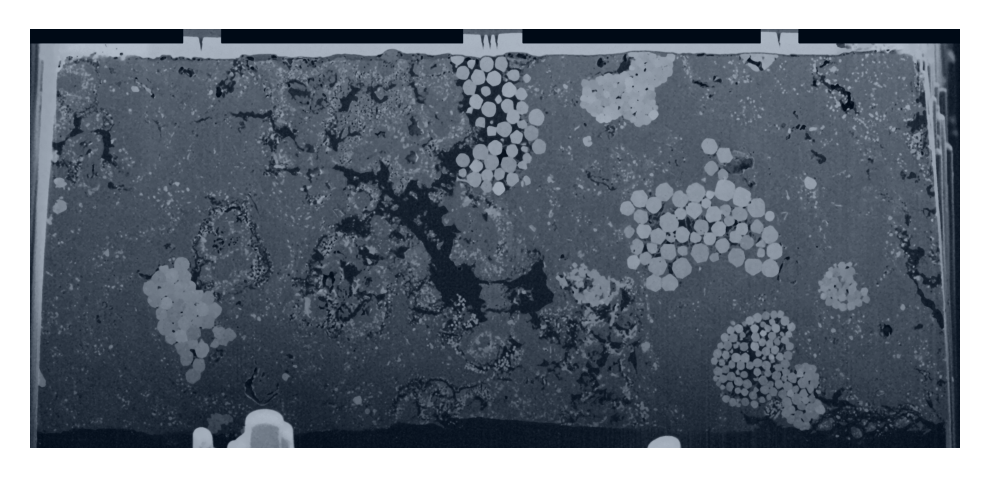

In [15]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1,1,figsize=(4,3),dpi=300)
axs.imshow(out['raw'],cmap='gray')
axs.imshow(np.where(out['annot']>0.5,1,0), alpha=0.3, cmap='cividis')
axs.axis("off")